In [1]:
# Import all the dependencies and define some helpful functions
import numpy as np
import random
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import logging as log
from src.plotting import *
%load_ext autoreload
%autoreload 2

# set plotting style
%matplotlib inline
plt.style.reload_library()
plt.style.use('ucla_presentations')
mpl.rcParams['text.usetex'] = False

# configure logging
log.basicConfig(level= log.INFO, format = '')


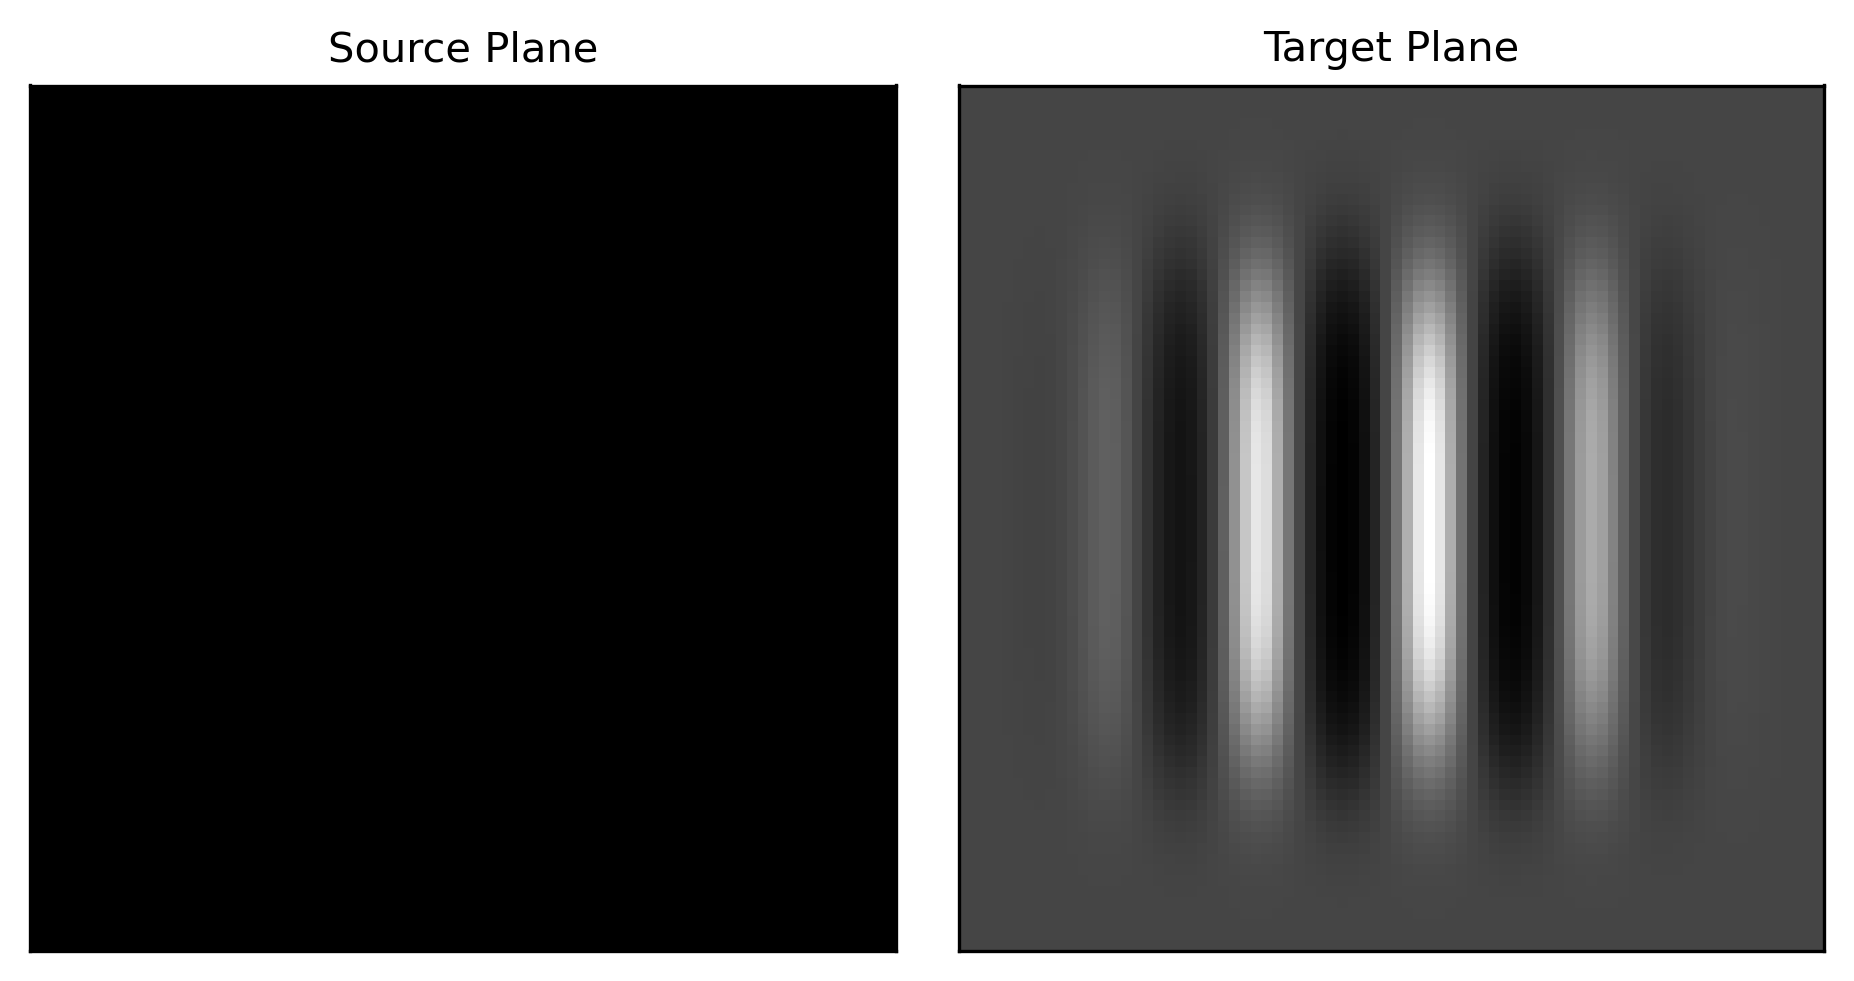

In [2]:
from scipy.io import loadmat

# Load in the benchmark images from binary Matlab files
data_dir = 'test_data/benchmark/'
tar_fname = data_dir + 'img_data.mat'
src_fname = data_dir + 'img_bg.mat'

tar_f = loadmat(tar_fname)
src_f = loadmat(src_fname)

tar_img = np.array(tar_f['img_data'], dtype=float)
src_img = np.array(src_f['img_bg'], dtype=float)

# Normalize the images
shape = tar_img.shape
N_pix = shape[0] * shape[1]
tar_img *= N_pix / np.sum(tar_img)
src_img *= N_pix / np.sum(src_img)

fig, (ax1, ax2) = plt.subplots(1,2)
Y, X = np.indices(tar_img.shape)

ax1.pcolormesh(X,Y, src_img, cmap='gray', vmax=tar_img.max())#, vmin = 0)
ax1.set_aspect('equal')
no_ticks(ax1)
ax1.set_title("Source Plane")

ax2.pcolormesh(X, Y, tar_img, cmap='gray', vmax=tar_img.max())#, vmin = 0)
ax2.set_aspect('equal')
no_ticks(ax2)
ax2.set_title("Target Plane")
plt.show()

In [3]:
%%time
from src import optimal_transport as ot

N = int(.8 * N_pix)
source = ot.initialize_sites(src_img, N)

Deploying N = 5120 sites on the source plane...
Performing Lloyd relaxation on the source plane...


Optimizing cell weights on the target plane (this will take a while)...
nfev = 0, f = -1310.8
nfev = 5, f = -1676.0
nfev = 10, f = -1973.0
nfev = 15, f = -2053.9
nfev = 20, f = -2267.5
nfev = 25, f = -2728.4
nfev = 30, f = -2966.3
nfev = 35, f = -3169.7
nfev = 40, f = -3281.1
nfev = 45, f = -3385.5
nfev = 50, f = -3438.7
nfev = 55, f = -3451.6
nfev = 60, f = -3456.2
nfev = 65, f = -3475.6
nfev = 70, f = -3500.7
nfev = 75, f = -3500.7
nfev = 80, f = -3500.7
nfev = 85, f = -3500.7
Minimization succeeded after 58 iterations and 89 power diagrams
Calculating the centroids of the optimized cells...
Moving nearest sites to the corners of the image...
Interpolating the displacements...
Calculating the deflection potential...
Finished


CPU times: user 2min 20s, sys: 2min 46s, total: 5min 7s
Wall time: 5min 3s


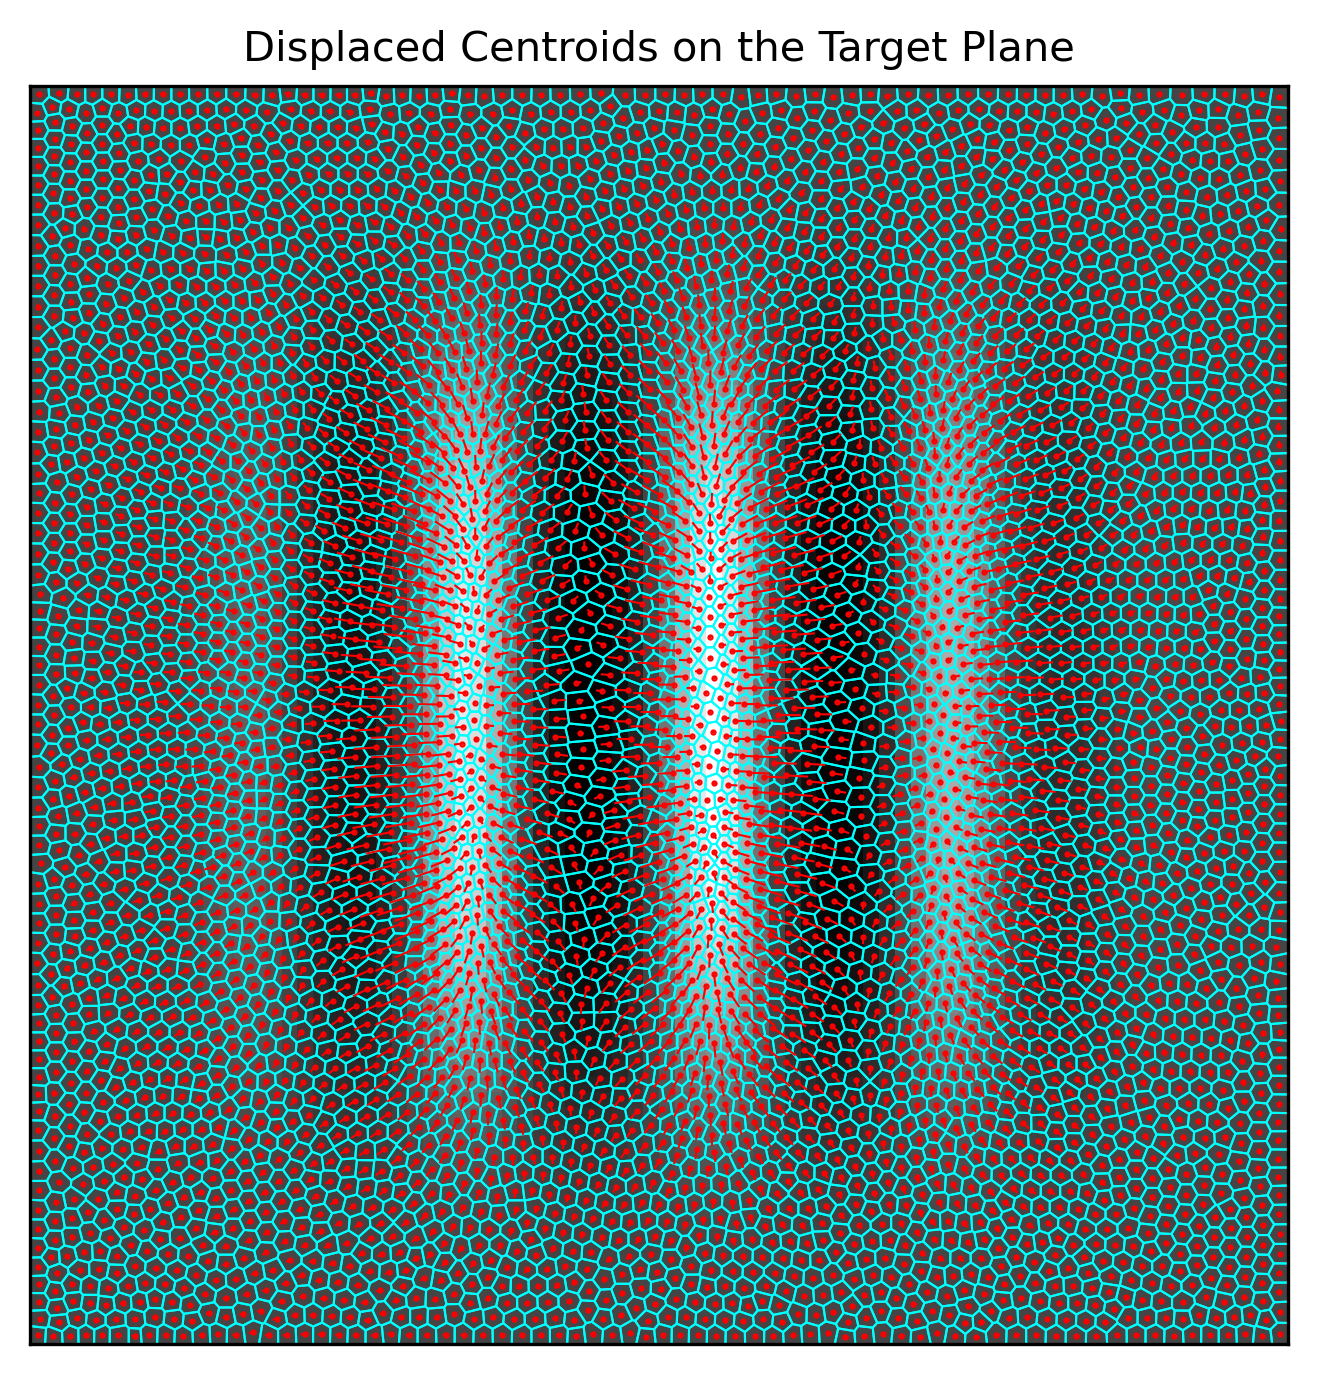

In [4]:
%%time
target, phi_c, a_x, a_y, result = ot.get_deflection_potential(tar_img, src_img, N, sites=source.sites, interp_method='linear')
ot.plot_displacements(target)

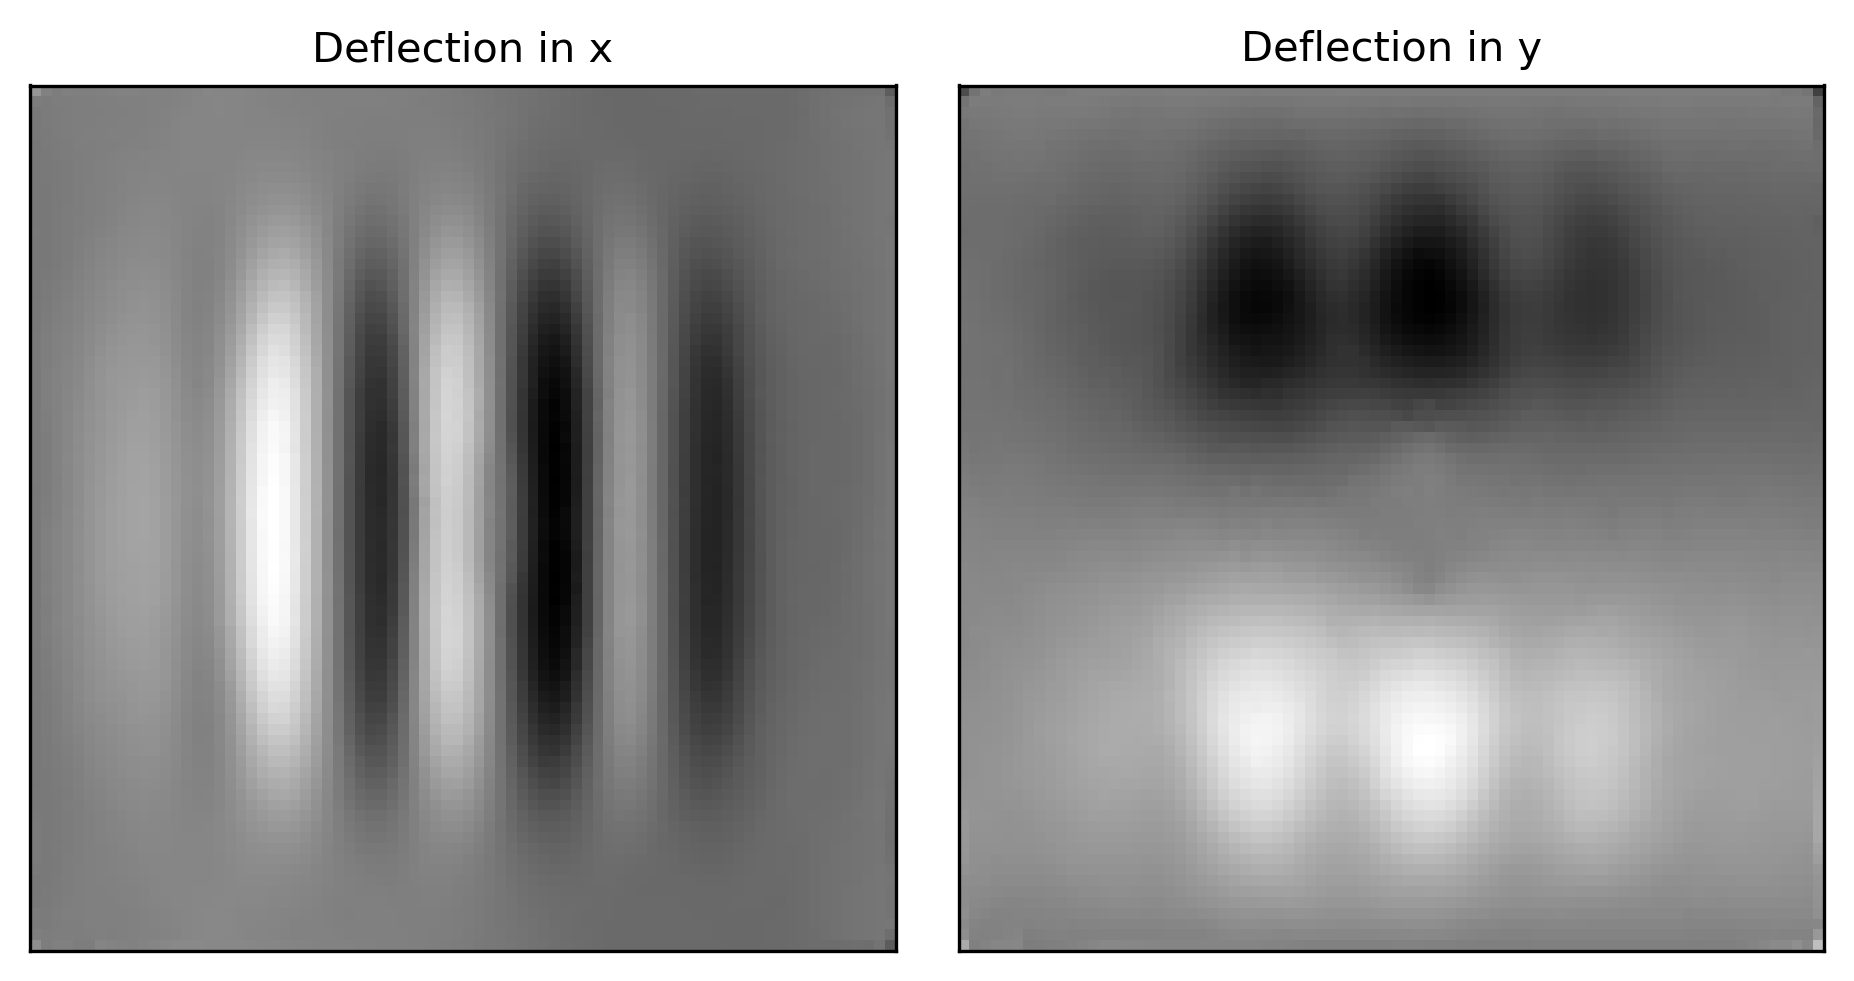

In [47]:
pad = 2

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.pcolormesh(X,Y, a_x, cmap='gray', vmax=a_x[pad:-pad, pad:-pad].max(), vmin = a_x[pad:-pad, pad:-pad].min())
ax1.set_aspect('equal')
no_ticks(ax1)
ax1.set_title("Deflection in x")

ax2.pcolormesh(X,Y, a_y, cmap='gray', vmax=a_y[pad:-pad, pad:-pad].max(), vmin = a_y[pad:-pad, pad:-pad].min())
ax2.set_aspect('equal')
no_ticks(ax2)
ax2.set_title("Deflection in y")
plt.show()

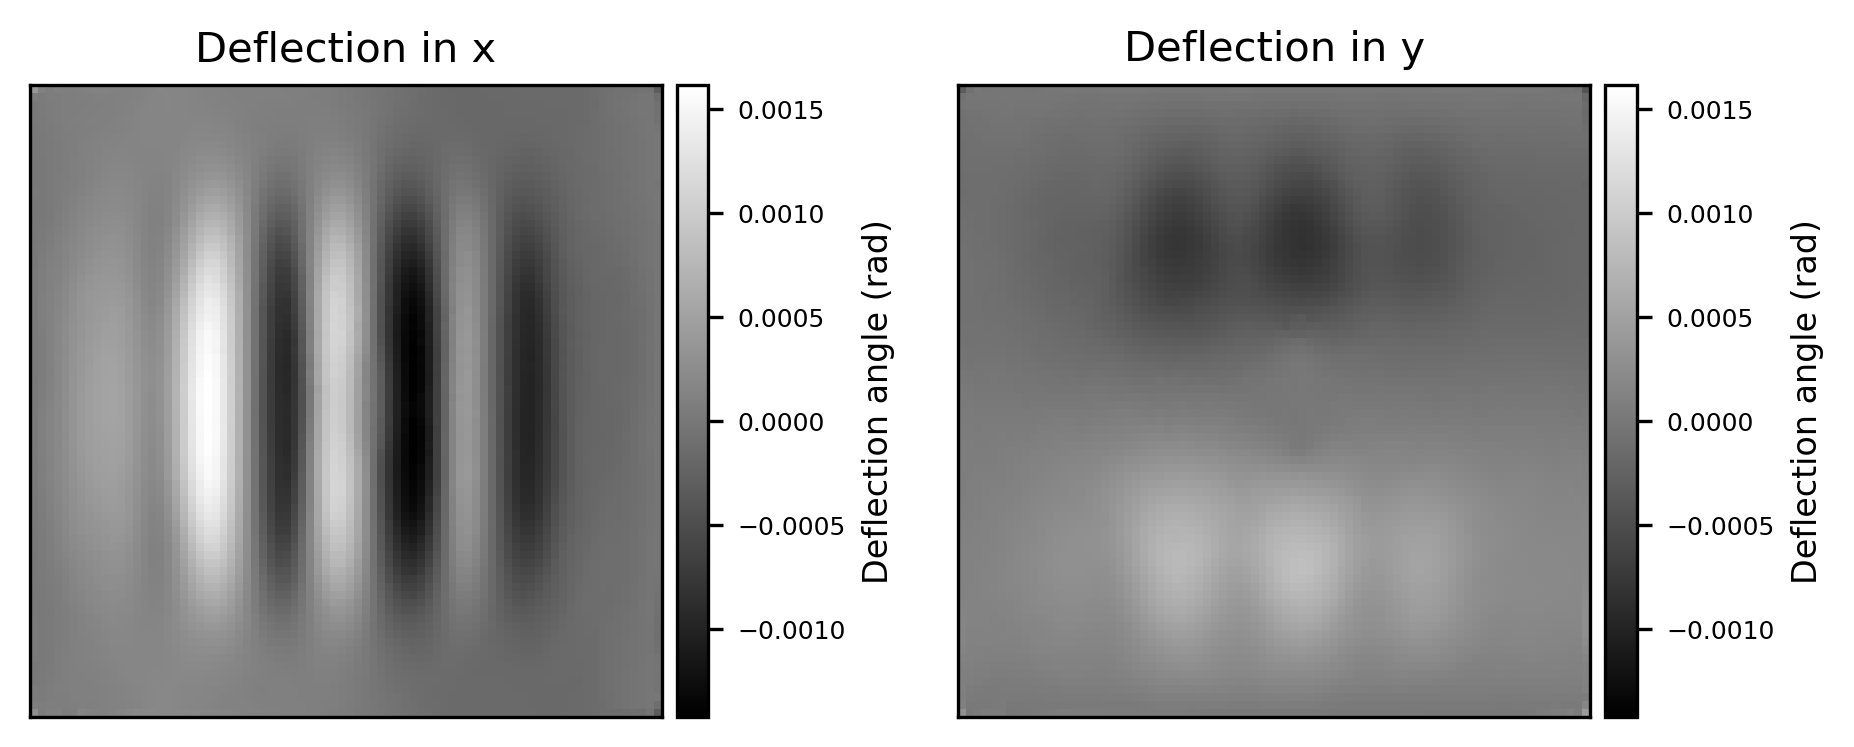

In [159]:
# Convert pixel displacement to deflection angle in radians
from astropy.constants import e, c, m_e
import astropy.units as u
from astropy.units import dimensionless_unscaled as dl
e = e.to(u.C)

pix_size = 10 * u.um 
tar_dist = 1  * u.cm
M = 1 # magnification

phi = -1 * phi_c / tar_dist * pix_size**2 * M
'''
angle_y, angle_x = np.gradient(phi)
angle_x *= -1
angle_y *= -1
'''
angle_x = a_x * (pix_size * M / tar_dist).to_value(dl)
angle_y = a_y * (pix_size * M / tar_dist).to_value(dl)

fig, (ax1, ax2) = plt.subplots(1,2)

im1 = ax1.pcolormesh(X,Y, angle_x, cmap='gray', vmax=angle_x[pad:-pad, pad:-pad].max(), vmin = angle_x[pad:-pad, pad:-pad].min())
ax1.set_aspect('equal')
cbar1 = colorbar(im1)
cbar1.set_label('Deflection angle (rad)')
no_ticks(ax1)
ax1.set_title("Deflection in x")

im2 = ax2.pcolormesh(X,Y, angle_y, cmap='gray', vmax=angle_x[pad:-pad, pad:-pad].max(), vmin = angle_x[pad:-pad, pad:-pad].min())
ax2.set_aspect('equal')
cbar2 = colorbar(im2)
cbar2.set_label('Deflection angle (rad)')

no_ticks(ax2)
ax2.set_title("Deflection in y")
plt.show()

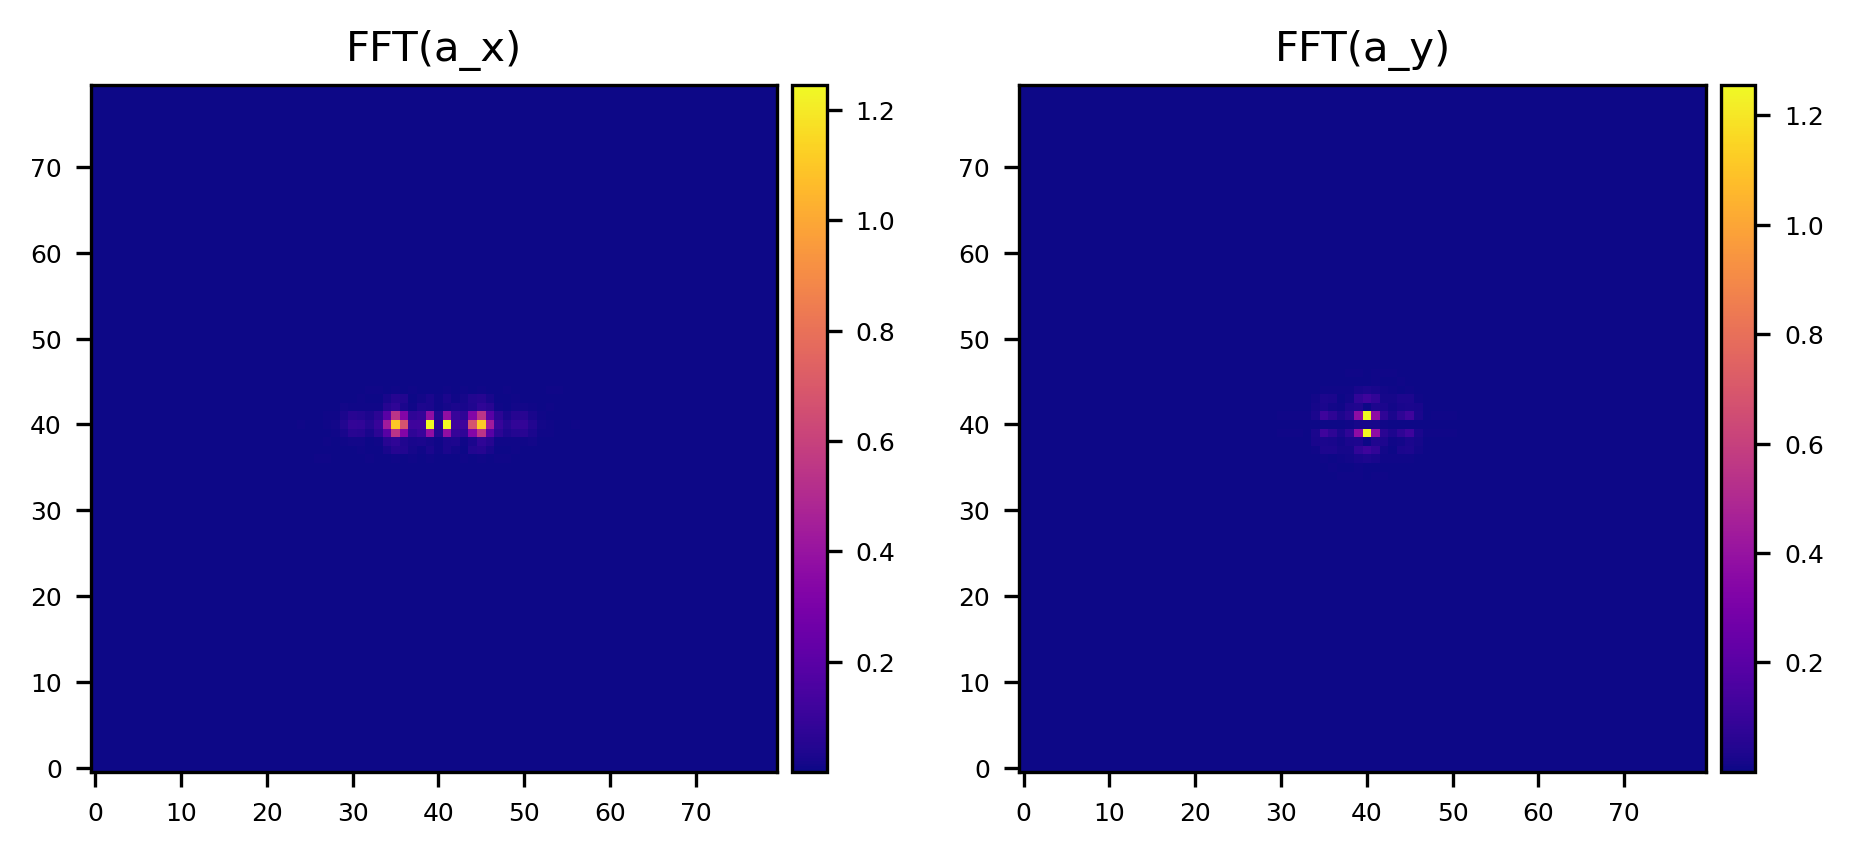

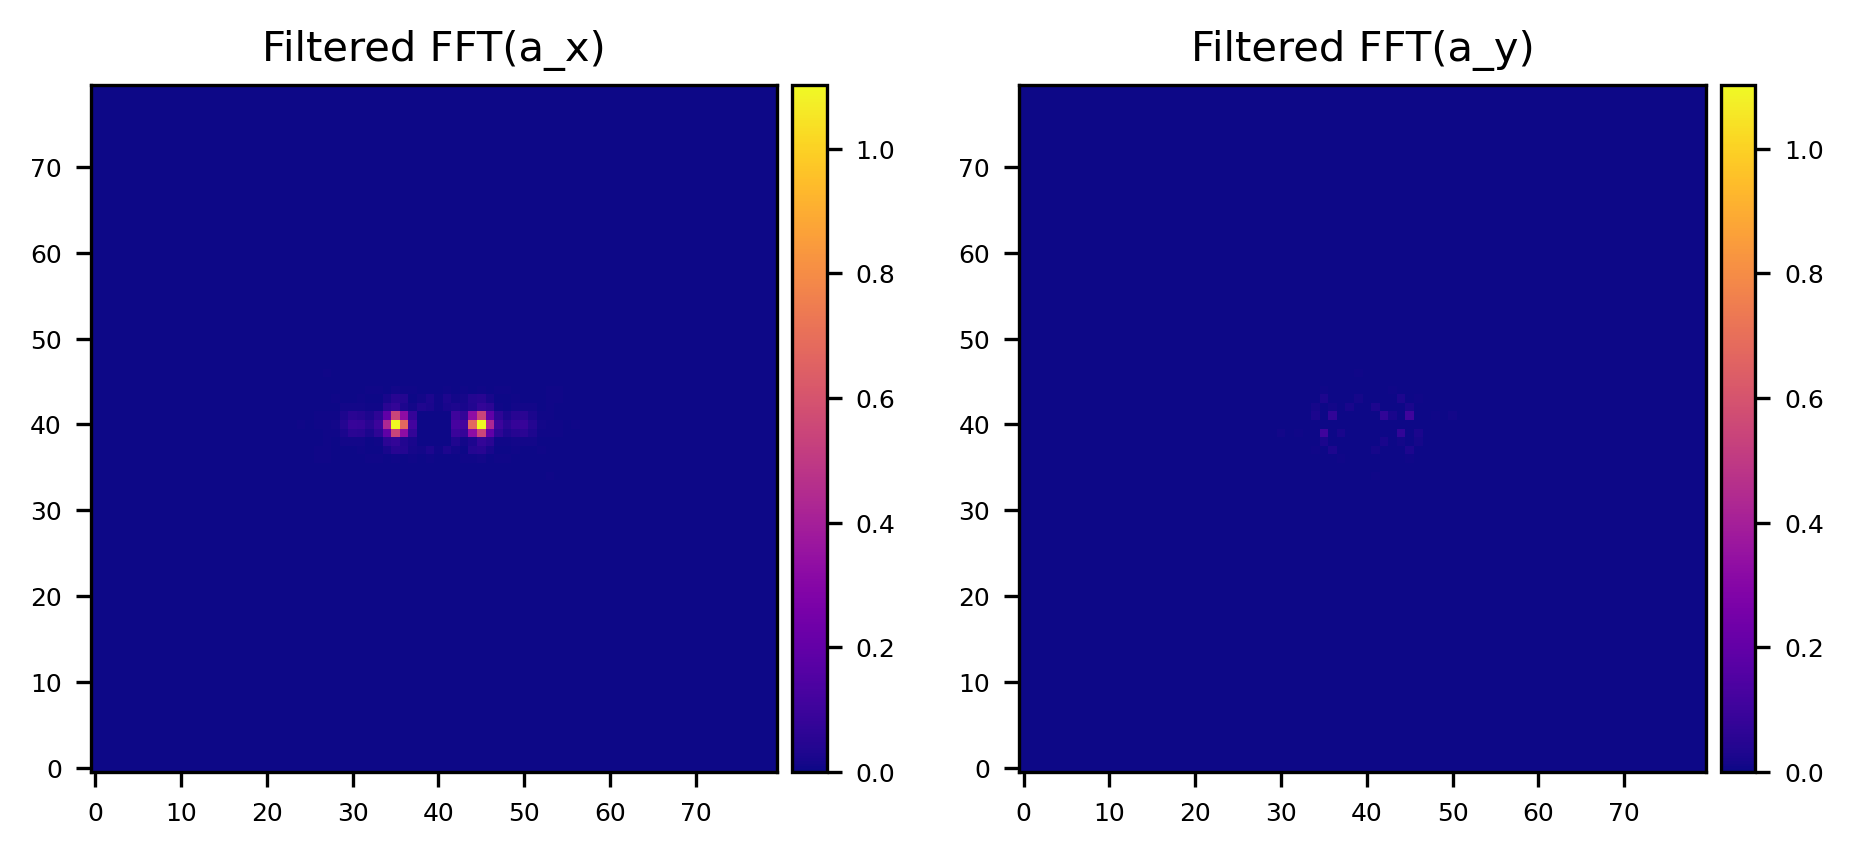

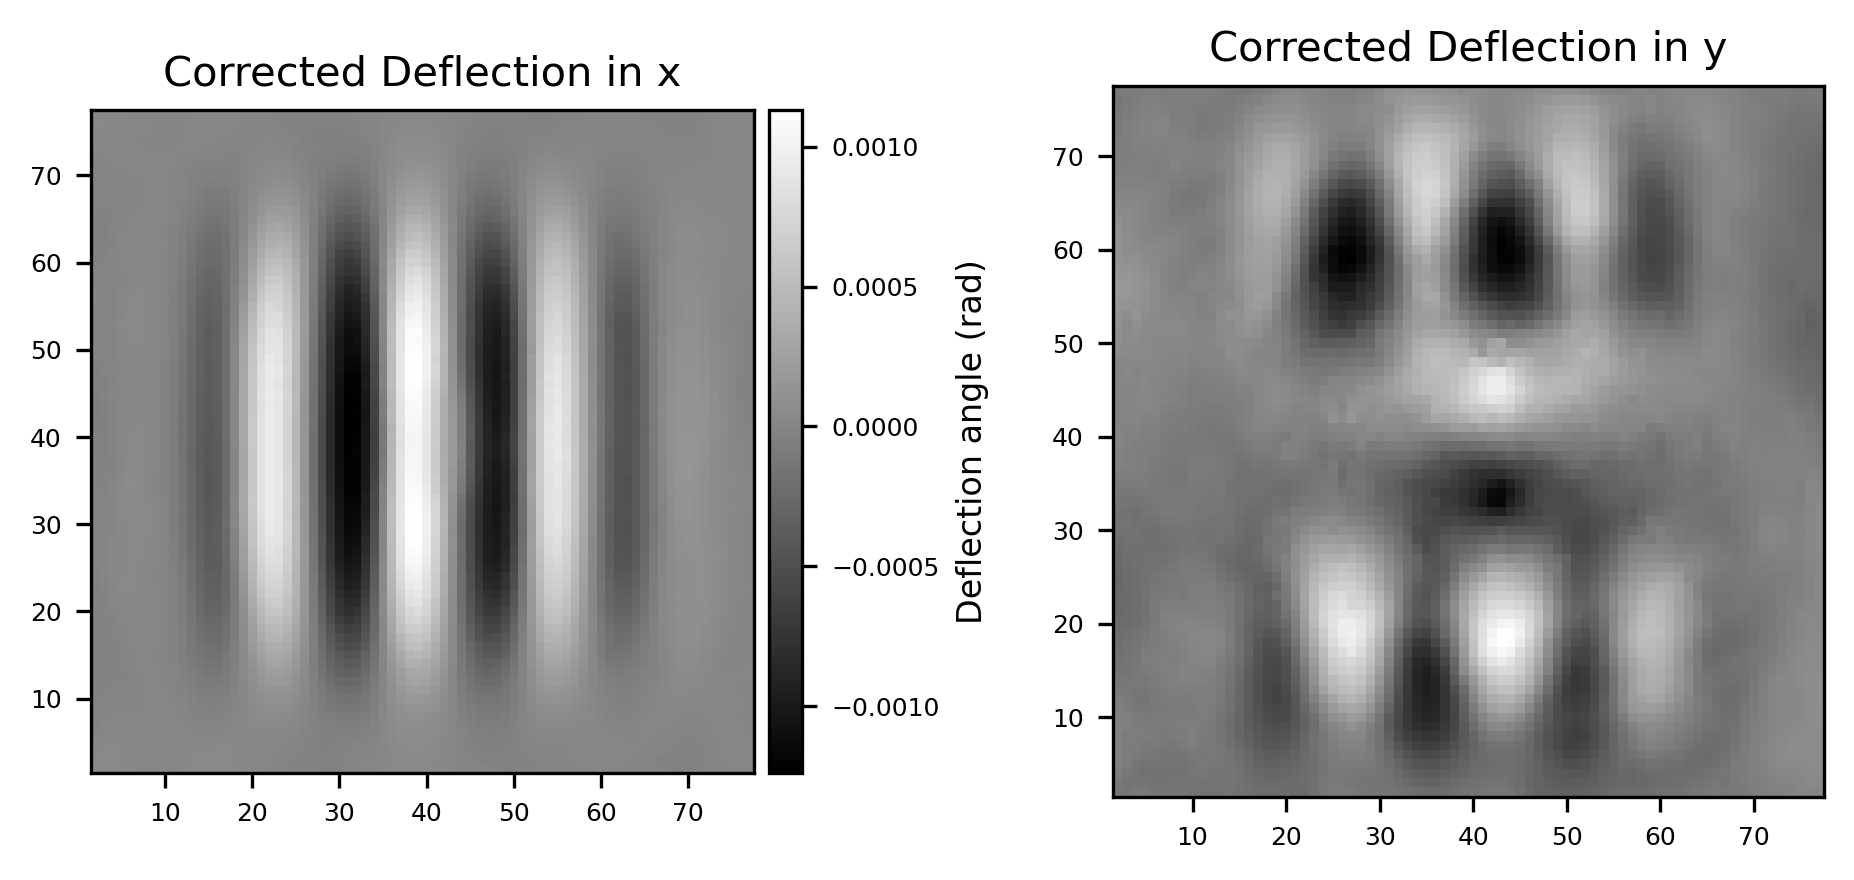

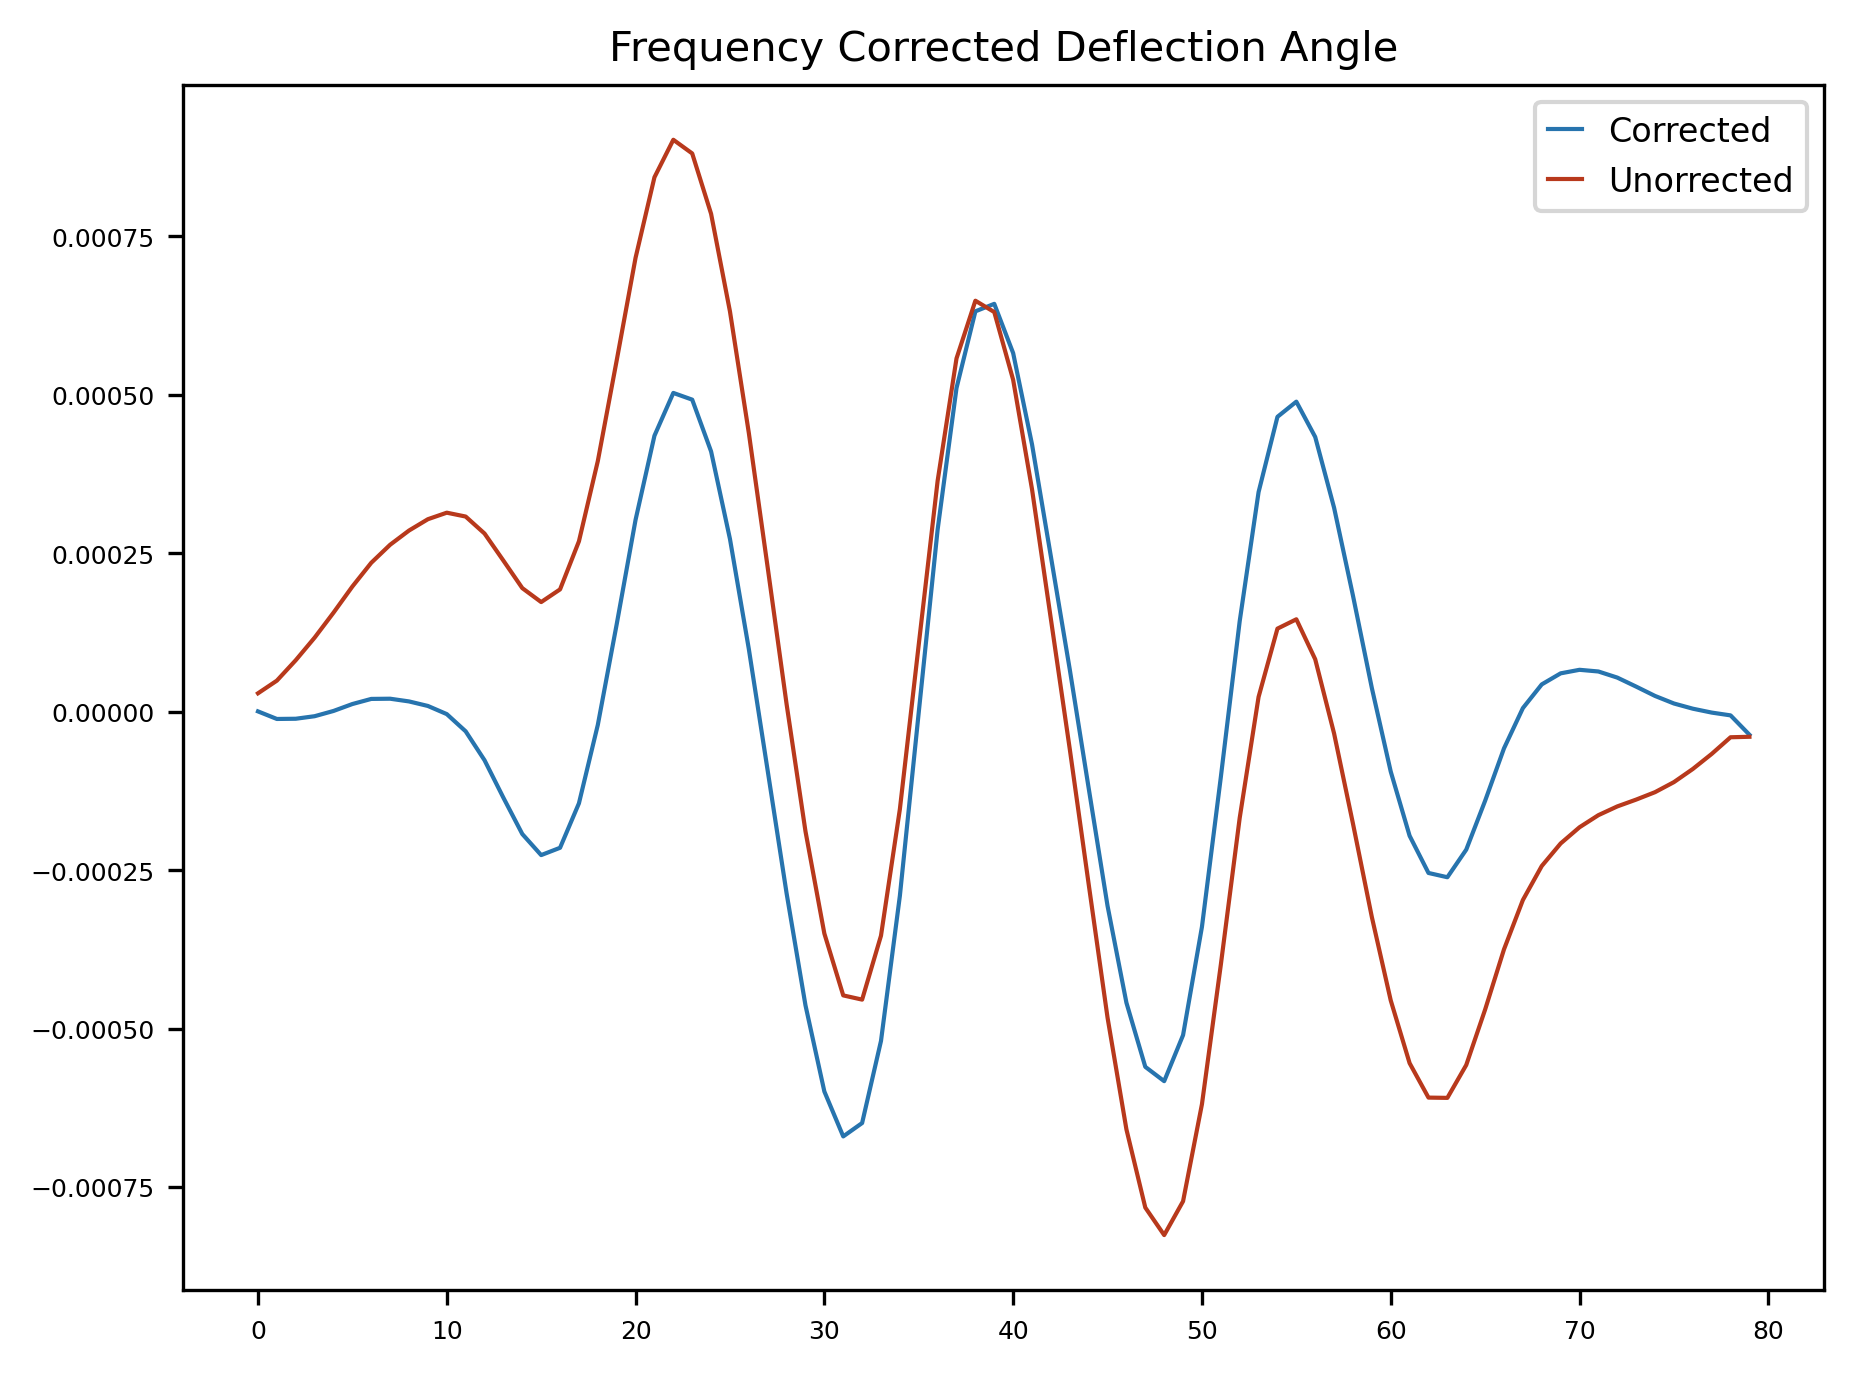

In [164]:
fftx = np.fft.fftshift(np.fft.fft2(angle_x))
ffty = np.fft.fftshift(np.fft.fft2(angle_y))
h, w = tar_img.shape

fig, (ax1, ax2) = plt.subplots(1,2)
im1 = ax1.pcolormesh(X,Y, np.abs(fftx), cmap='plasma')
ax1.set_aspect('equal')
cbar1 = colorbar(im1)
ax1.set_title("FFT(a_x)")

#im2 = ax2.pcolormesh(X,Y, ffty.real, cmap='plasma', vmax=fftx[pad:-pad, pad:-pad].real.max(), vmin = fftx[pad:-pad, pad:-pad].real.min())
im2 = ax2.pcolormesh(X,Y, np.abs(ffty), cmap='plasma')
ax2.set_aspect('equal')
cbar2 = colorbar(im2)

ax2.set_title("FFT(a_y)")
plt.show()

fftx[h//2 -2:h//2 +2, w//2 -2:w//2 +2] = 0
ffty[h//2 -2:h//2 +2, w//2 -2:w//2 +2] = 0
ax_corrected = np.fft.ifft2(np.fft.ifftshift(fftx)).real
ay_corrected = np.fft.ifft2(np.fft.ifftshift(ffty)).real

fig, (ax1, ax2) = plt.subplots(1,2)
im1 = ax1.pcolormesh(X,Y, np.abs(fftx), cmap='plasma')
ax1.set_aspect('equal')
cbar1 = colorbar(im1)
ax1.set_title("Filtered FFT(a_x)")

im2 = ax2.pcolormesh(X,Y, ffty.real, cmap='plasma', vmax=np.abs(fftx).max(), vmin = np.abs(fftx).min())
ax2.set_aspect('equal')
cbar2 = colorbar(im2)

ax2.set_title("Filtered FFT(a_y)")
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2)

im1 = ax1.pcolormesh(X[pad:-pad, pad:-pad],Y[pad:-pad, pad:-pad], ax_corrected[pad:-pad, pad:-pad], cmap='gray', vmax=ax_corrected[pad:-pad, pad:-pad].max(),vmin=ax_corrected[pad:-pad, pad:-pad].min())
ax1.set_aspect('equal')
cbar1 = colorbar(im1)
cbar1.set_label('Deflection angle (rad)')
ax1.set_title("Corrected Deflection in x")

im2 = ax2.pcolormesh(X[pad:-pad, pad:-pad],Y[pad:-pad, pad:-pad], ay_corrected[pad:-pad, pad:-pad], cmap='gray', vmax=ay_corrected[pad:-pad, pad:-pad].max(), vmin=ay_corrected[pad:-pad, pad:-pad].min())
ax2.set_aspect('equal')
cbar2.set_label('Deflection angle (rad)')

ax2.set_title("Corrected Deflection in y")
plt.show()

fig, ax = plt.subplots()

ax.plot(np.mean(ax_corrected, axis=0), label='Corrected')
ax.plot(np.mean(angle_x, axis=0), label='Unorrected')
ax.legend()
ax.set_title("Frequency Corrected Deflection Angle")

plt.show()

0.010118273044600633
13.987568392717915


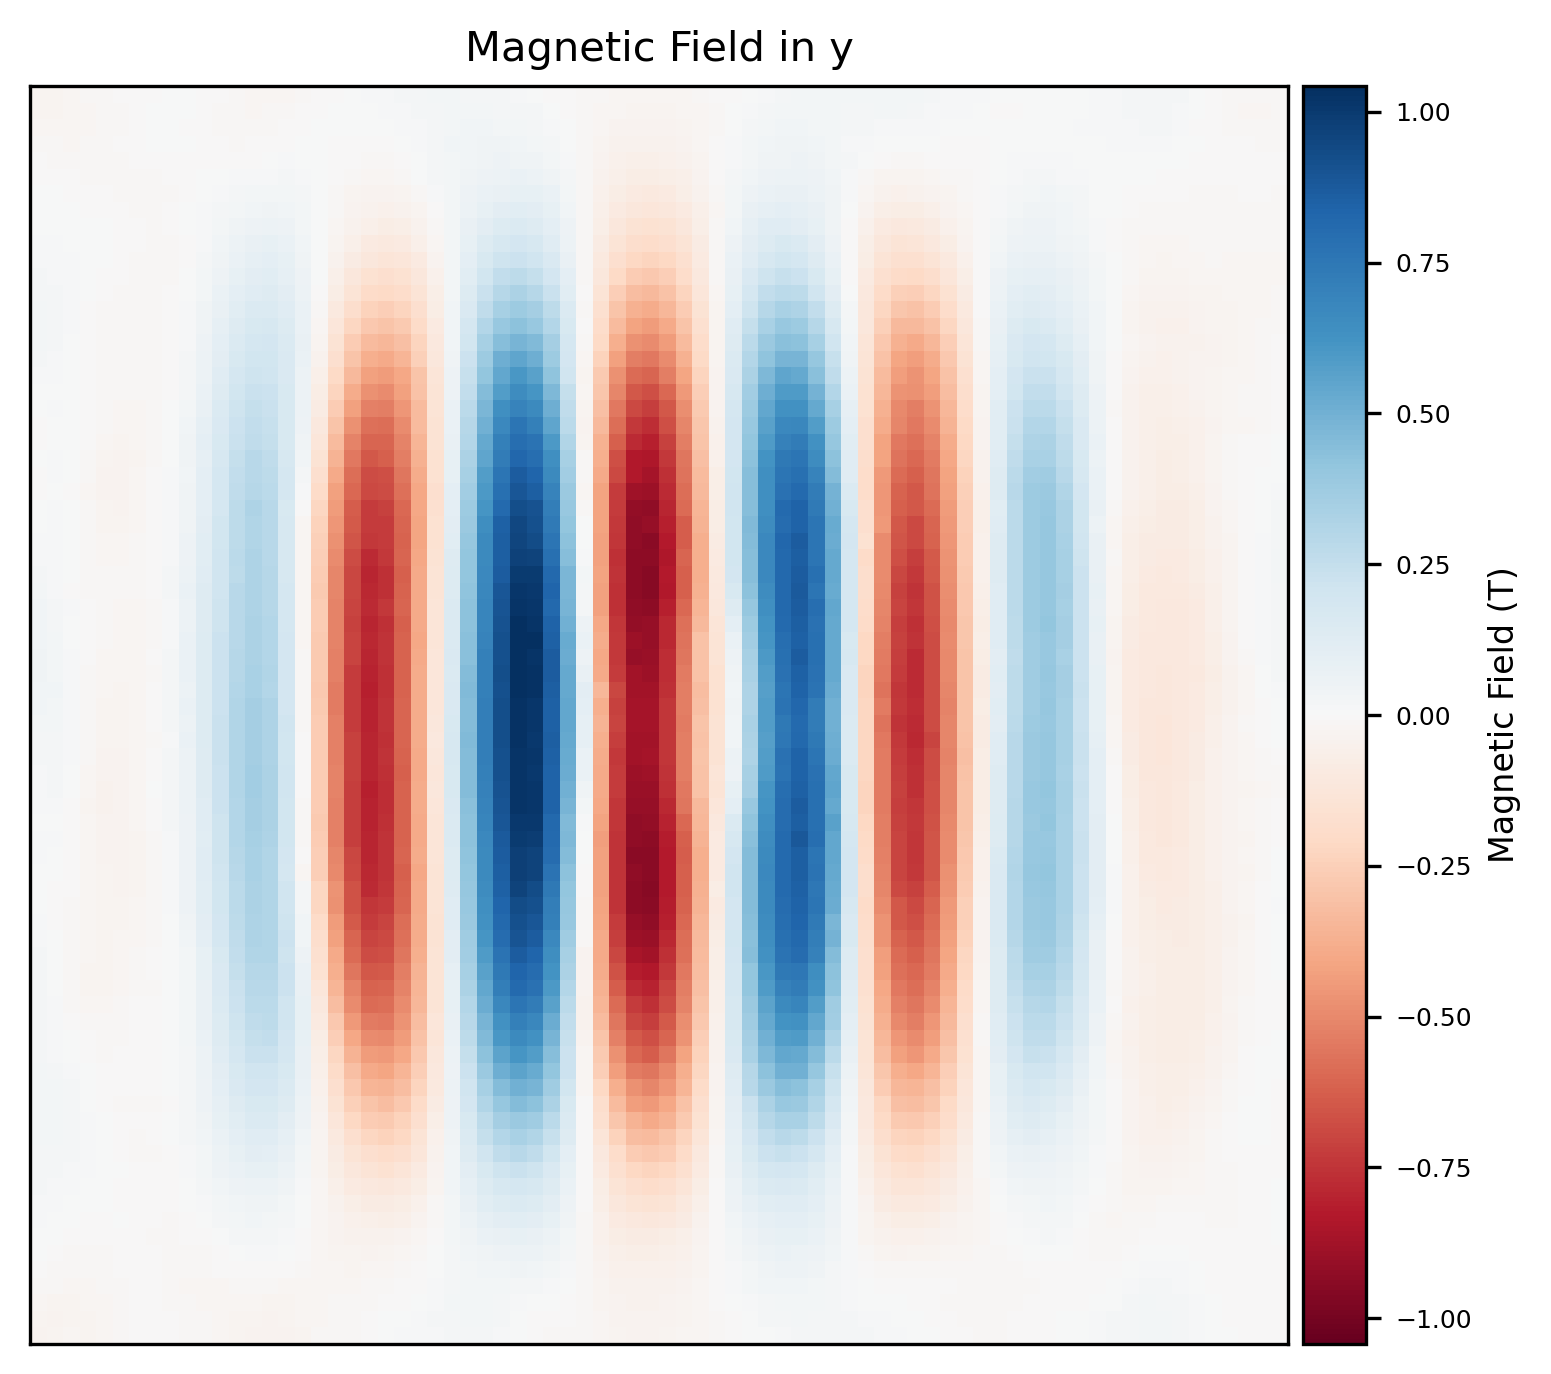

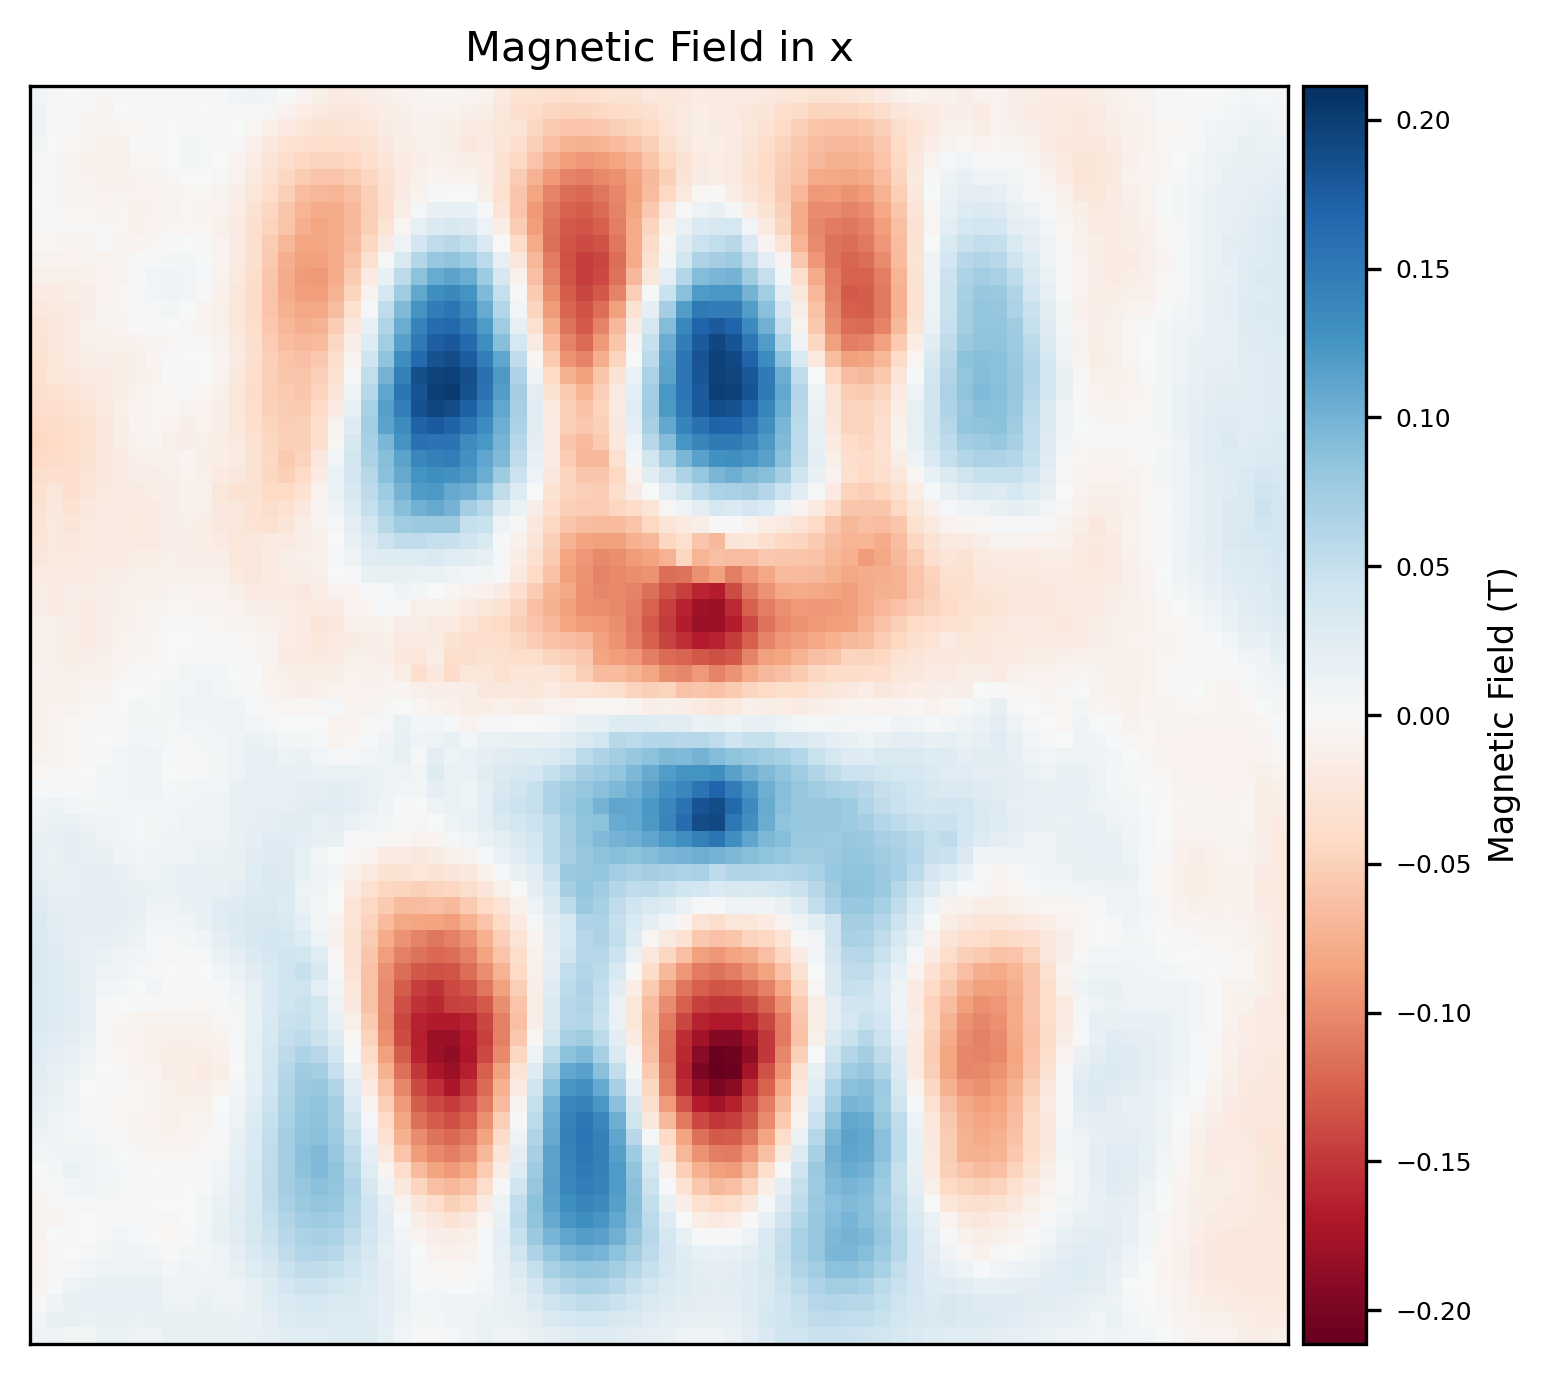

In [165]:
from astropy.constants import e, c, m_e
import astropy.units as u
e = e.to(u.C)

W = 200 * u.um
E = 50.5 * u.MeV

gamma = (E / (m_e * c**2)).to(u.dimensionless_unscaled)

By = (ax_corrected * np.sqrt(gamma**2 - 1) * m_e * c /  (-e * W)).to(u.T)
Bx = (ay_corrected * np.sqrt(gamma**2 - 1) * m_e * c /  (-e * W)).to(u.T)

# Nonrelativistic equations:
#By = (ax_corrected * np.sqrt(2 * m_e * E) / ( -e * W)).to(u.T)
#Bx = (ay_corrected * np.sqrt(2 * m_e * E) / ( -e * W)).to(u.T)

fig, ax = plt.subplots()

im = ax.pcolormesh(X[pad:-pad, pad:-pad],Y[pad:-pad, pad:-pad], By[pad:-pad, pad:-pad], cmap='RdBu',vmax = max(By[pad:-pad, pad:-pad].max(), abs(By[pad:-pad, pad:-pad].min())).value, vmin = -1* max(By[pad:-pad, pad:-pad].max(), abs(By[pad:-pad, pad:-pad].min())).value)
ax.set_aspect('equal')
cbar = colorbar(im)
cbar.set_label('Magnetic Field (T)')
no_ticks(ax)
ax.set_title("Magnetic Field in y")

plt.show()

fig, ax = plt.subplots()

im = ax.pcolormesh(X[pad:-pad, pad:-pad],Y[pad:-pad, pad:-pad], Bx[pad:-pad, pad:-pad], cmap='RdBu', vmax = max(Bx[pad:-pad, pad:-pad].max(), abs(Bx[pad:-pad, pad:-pad].min())).value, vmin = -1* max(Bx[pad:-pad, pad:-pad].max(), abs(Bx[pad:-pad, pad:-pad].min())).value)
ax.set_aspect('equal')
cbar = colorbar(im)
cbar.set_label('Magnetic Field (T)')
no_ticks(ax)
ax.set_title("Magnetic Field in x")

plt.show()

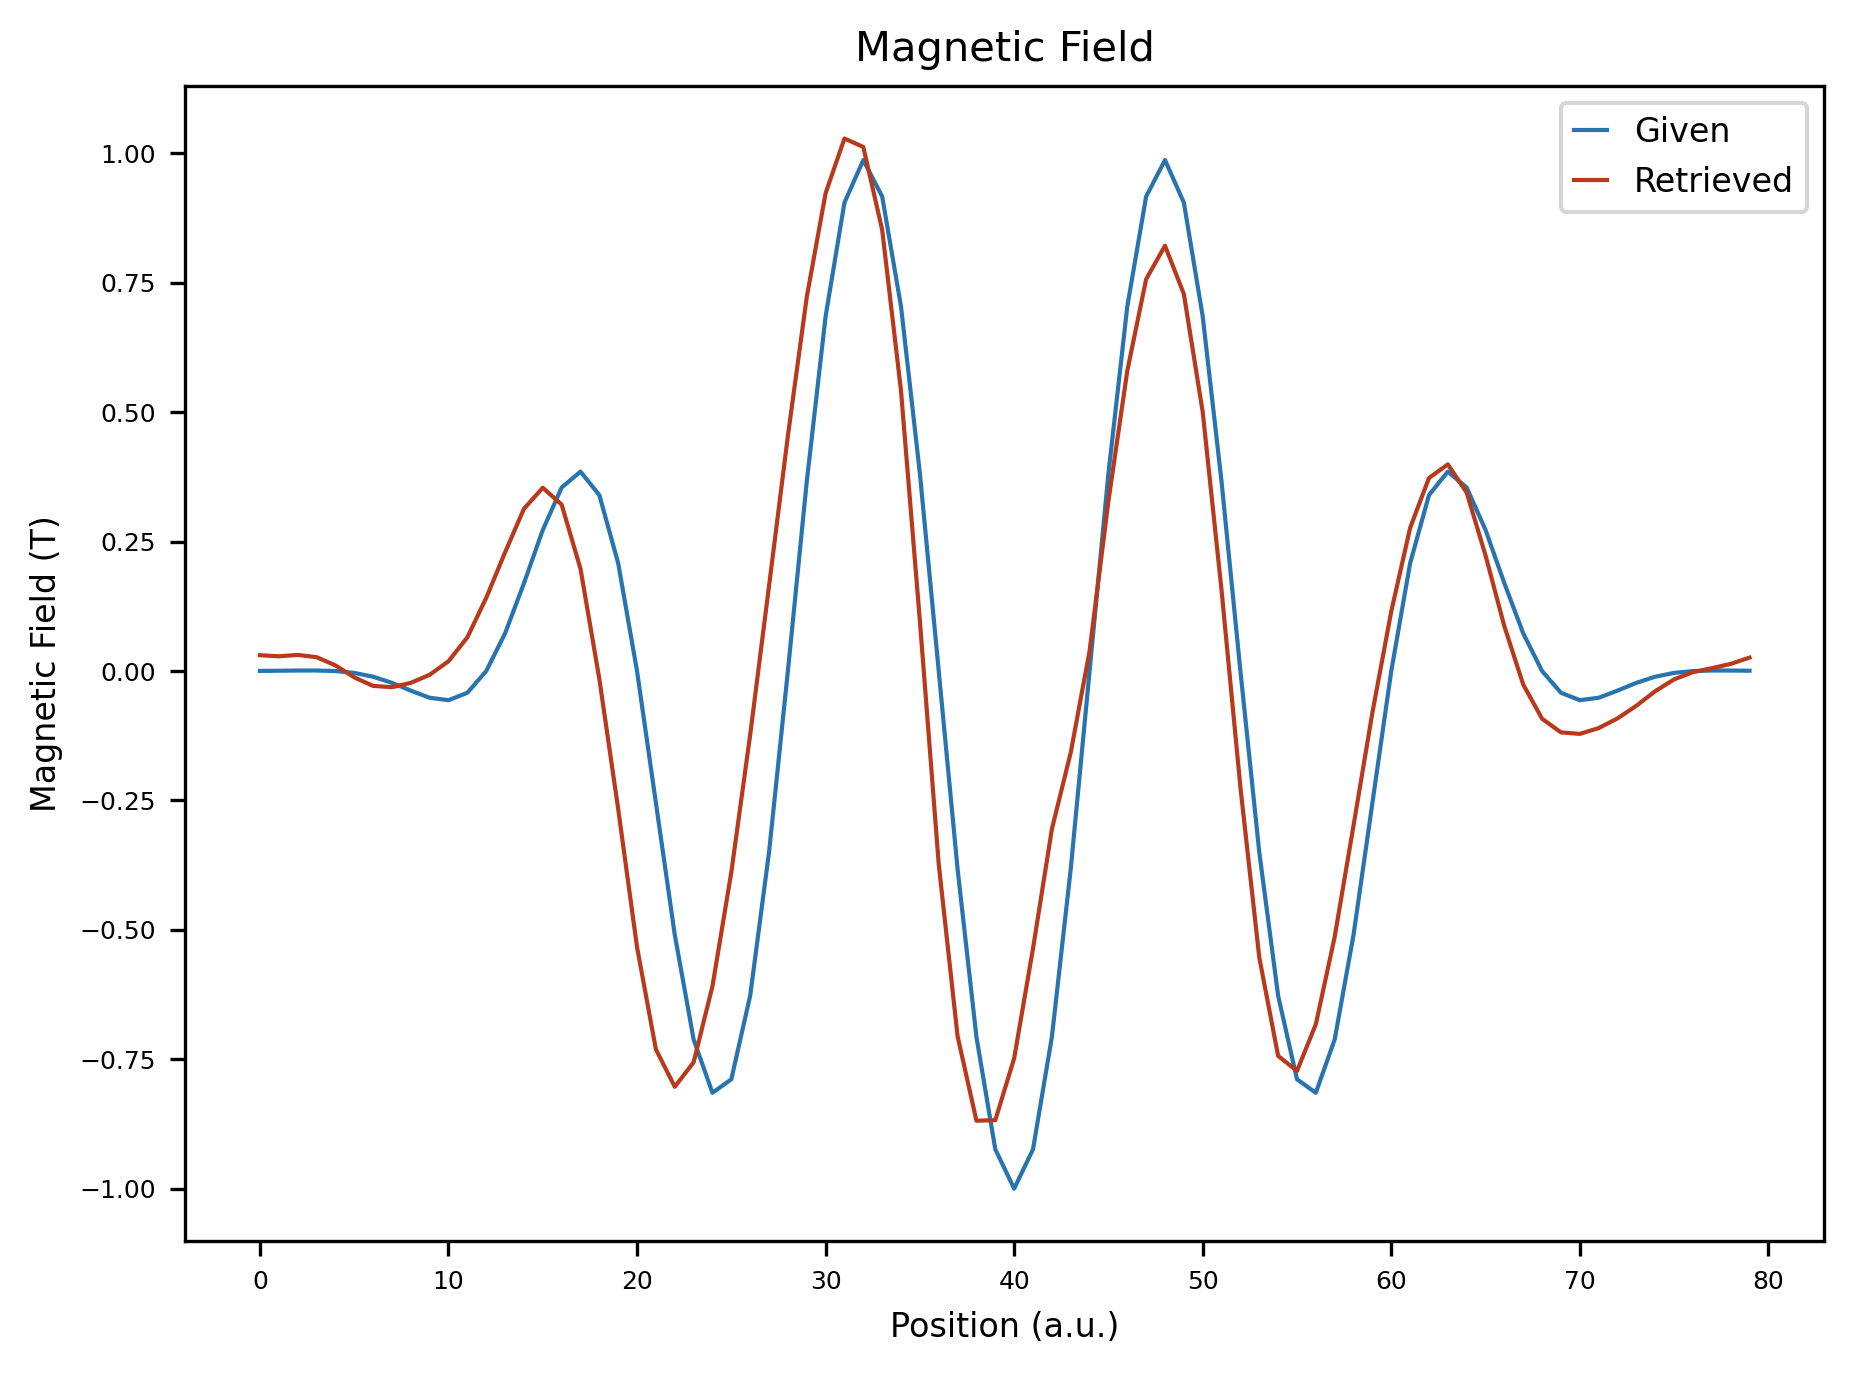

In [163]:
fig, ax = plt.subplots()
ax.set_title("Magnetic Field")

Y, X = np.indices(tar_img.shape)

sig = 20

B_given = np.cos(2 * np.pi * X / 16.) * np.exp(-1* (X-w/2.)**4 / (2*sig**4) - (Y-w/2.)**4 / (2*sig**4))
ax.plot(np.mean(B_given[h//2-1: h//2+1], axis=0), label='Given')
ax.plot(np.mean(By[h//2-1: h//2+1], axis=0), label='Retrieved')
#ax.plot(np.mean(By_proper[h//2-1: h//2+1], axis=0), label='Scaled')


ax.set_ylabel('Magnetic Field (T)')
ax.set_xlabel('Position (a.u.)')
ax.legend()
plt.show()

In [166]:
np.savez(data_dir+'results.npz',
        source_image = src_img,
        target_image = tar_img,
        sites = target.sites,
        weights = target.weights,
        centroids = target.c,
        phi = phi_c,
        ax = a_x,
        ay = a_y)